# Applications of using LSTM to emulate PID controller
The LSTM is shown to closely approximate the PID controller in 03Emulate_PID.ipynb. In addition, the PID tuning parameters can be perturbed for different behavior. This is shown in the red portion of the graphs and can be changed with the start_anom variable. This simulates a "bad actor" operator intentionally adjusting the controller parameters for poor performance. The LSTM comparison clearly shows when the PID controller has started to behave erratically. Note that if the PID controller tuning parameters are intentionally changed, the LSTM should be retrained. 

In [1]:
import tclab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from tqdm import tqdm # Progress bar
import imageio

# For LSTM model
from keras.models import load_model

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
TCLab disconnected successfully.


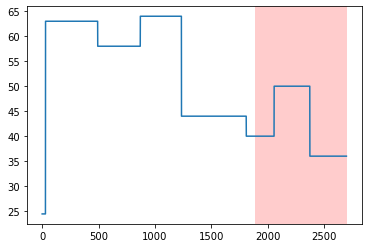

In [2]:
#### Set up run ####

# Import model and model parameters
model = load_model('pid_emulate.h5')
model_params = pickle.load(open('model_params.pkl', 'rb'))

s_x = model_params['Xscale']
s_y = model_params['yscale']
window = model_params['window']

# Run time in minutes
run_time = 45.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Qpid = np.zeros(loops) # Heater values for PID controller
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.zeros(loops) # Time
t_pid = np.zeros(loops) # Time to compute PID controller output
t_lstm = np.zeros(loops) # Time to compute LSTM controller output
Q2 = np.zeros(loops)

# Time range to introduce anomaly (turn on heater 2, change PID tuning constants)
start_anom = int(0.7*loops)

# Heater 2 turned on during anomaly window
Q2[start_anom:] = 80

# Temperature set point (degC)
with tclab.TCLab() as lab:
    Tsp = np.ones(loops) * lab.T1

# vary temperature setpoint
end = window + 15 # leave 1st window + 15 seconds of temp set point as room temp
while end <= start_anom: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp[start:end] = random.randint(30,70)
    
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp[start:end] = random.randint(30,50)
    
# Plot
plt.plot(Tsp)
plt.axvspan(start_anom,loops,facecolor='r',alpha=0.2);

In [3]:
# PID Parameters
Kc0   = 6.0
tauI0 = 75.0 # sec
tauD0 = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt,Kc,tauI,tauD):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

In [4]:
#-----------------------------------------
# LSTM Controller
#-----------------------------------------

def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100
    Q1c = np.clip(Q1c,0.0,100.0)
    
    return Q1c

# Test A: Heater 2 turned on

In [5]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    start_time = time.time()
    t = start_time

    for i in tqdm(range(loops)):
        # Delay 1 second
        if time.time() > t + 1.0:
            print('Exceeded cycle time by ',time.time()-t-1.0)
        else:
            while time.time() < t + 1.0:
                pass

        # Record time and change in time
        t = time.time()
        tm[i] = t - start_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Timer for LSTM controller output
            t0_lstm = time.time()
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            tf_lstm = time.time()

        # Write heater output (0-100)
        lab.Q1(Qlstm[i])
        lab.Q2(Q2[i])

        # Generate images to make a gif; only need every 10 images
        if i%10 == 0:
            plt.figure(figsize=(10,4))
            plt.plot(Tsp,'k-',label='SP $(^oC)$')
            plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
            plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
            plt.axvspan(start_anom,loops,facecolor='r',alpha=0.2,label='Q2 on')
            plt.ylim((0,100))
            plt.xlabel('Time (s)',size=14)
            plt.xticks(size=12)
            plt.yticks(size=12)
            if i < loops/2:
                plt.legend(fontsize=14,loc='upper right')
            else:
                plt.legend(fontsize=14,loc='upper left')


            num = str(i)
            num = num.zfill(len(str(loops)))
            filename='./figures/heater_anom_'+num+'.png'
            plt.savefig(filename)
            plt.close()

TCLab version 0.4.9


  0%|                                                                | 0/2700 [00:00<?, ?it/s]

Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 23.80 °C
Temperature 2: 23.51 °C


100%|█████████████████████████████████████████████████████| 2700/2700 [45:02<00:00,  1.00s/it]

TCLab disconnected successfully.


In [6]:
# Generate gif
images = []
for i in range(0,loops,10):
    num = str(i)
    num = num.zfill(len(str(loops)))
    filename='./figures/heater_anom_'+num+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave('heater_anomaly.gif', images)

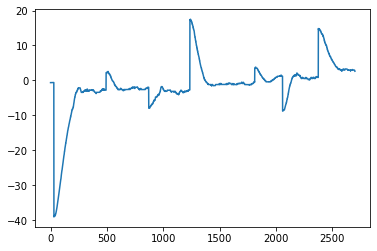

In [7]:
# Plot error 
err = T1 - Tsp
plt.plot(err)

# Test B: PID parameters changed
Also find the time required to run LSTM and PID calculations

In [8]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in tqdm(range(loops)):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp[i]-T1[i])

        # Perturb PID tuning parameter
        if i > start_anom:
            Kc, tauI, tauD = 3.0*Kc0, 0.5*tauI0, tauD0 + 2.0
        else:
            Kc, tauI, tauD = Kc0, tauI0, tauD0
            
        # Calculate PID output (and time)
        t0_pid = time.time()
        [Qpid[i],P,ierr,D] = pid(Tsp[i],T1[i],T1[i-1],ierr,dt,
                                 Kc=Kc,tauI=tauI,tauD=tauD)
        tf_pid = time.time()

        # Write heater output (0-100)
        lab.Q1(Qpid[i])
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            t0_lstm = time.time()
            Qlstm[i] = lstm(T1_m,Tsp_m)
            tf_lstm = time.time()
            
        # Save controller times
        t_pid[i] = tf_pid - t0_pid
        t_lstm[i] = tf_lstm - t0_lstm
            
        # Generate images to make a gif; only need every 10 images
        if i%10 == 0:
            plt.figure(figsize=(10,4))
            plt.plot(Tsp,'k-',label='SP $(^oC)$')
            plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
            plt.plot(Qpid[:i],'b-',label='$Q_{PID}$ (%)')
            plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
            plt.axvspan(start_anom,loops,facecolor='r',alpha=0.2)
            plt.ylim((0,100))
            plt.xlabel('Time (s)',size=14)
            plt.xticks(size=12)
            plt.yticks(size=12)
            if i < loops/2:
                plt.legend(fontsize=14,loc='upper right',ncol=2)
            else:
                plt.legend(fontsize=14,loc='upper left',ncol=2)

            num = str(i)
            num = num.zfill(len(str(loops)))
            filename='./figures/pid_anom_'+num+'.png'
            plt.savefig(filename)
            plt.close()

TCLab version 0.4.9


  0%|                                                                | 0/2700 [00:00<?, ?it/s]

Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 38.62 °C
Temperature 2: 48.32 °C


 16%|████████▍                                             | 421/2700 [07:02<50:20,  1.33s/it]

Exceeded cycle time by  0.12419509887695312


100%|█████████████████████████████████████████████████████| 2700/2700 [45:01<00:00,  1.00s/it]

TCLab disconnected successfully.


In [9]:
# Generate gif from saved images
images = []
for i in range(0,loops,10):
    num = str(i)
    num = num.zfill(len(str(loops)))
    filename='./figures/pid_anom_'+num+'.png'
    images.append(imageio.imread(filename))
imageio.mimsave('pid_anomaly.gif', images)

LSTM time: [0.03020024 0.03020024 0.03020024 ... 0.02890253 0.02999902 0.02989316] s
PID time:  [0. 0. 0. ... 0. 0. 0.] s


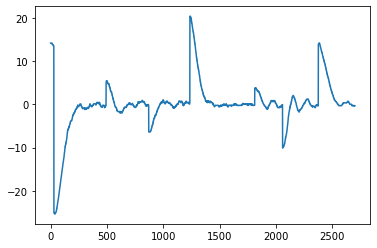

In [10]:
# Plot error 
err = T1 - Tsp
plt.plot(err)

# Display time
print('LSTM time:',t_lstm,'s')
print('PID time: ',t_pid,'s')